# Imports

In [52]:
import random
import numpy as np
import tkinter as tk
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.datasets import cifar100
from keras.models import Model, load_model
from tkinter import filedialog, messagebox
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Input, MaxPool2D, BatchNormalization, add

# Dataset

In [42]:
# cargar dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# labels de animales
animal_labels = [1, 3, 4, 6, 7, 14, 15, 18, 19, 21, 24, 26, 27, 30, 31, 32,
                 34, 36, 38, 42, 43, 44, 45, 50, 55, 63, 64, 65, 66, 67, 72,
                 73, 75, 77, 78, 79, 80, 88, 91, 93, 95, 97, 99]

# escoger solo imagenes de animales
x_train = x_train[np.isin(y_train, animal_labels).flatten()]
x_test = x_test[np.isin(y_test, animal_labels).flatten()]

# mezclar las imagenes
np.random.shuffle(x_train)
np.random.shuffle(x_test)

# normalizar imagenes
x_train = x_train / 255
x_test = x_test / 255

print("Dataset de entrenamiento:", x_train.shape)
print("Dataset de testing:", x_test.shape)

Dataset de entrenamiento: (21500, 32, 32, 3)
Dataset de testing: (4300, 32, 32, 3)


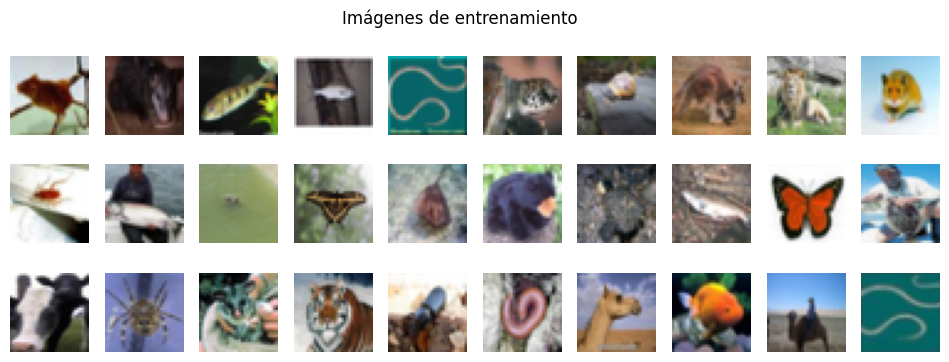

In [43]:
def show(images, title):
    fig, axes = plt.subplots(3, 10, figsize=(12, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')

    plt.suptitle(title)
    plt.show()

show(x_train, "Imágenes de entrenamiento")

## Ruido

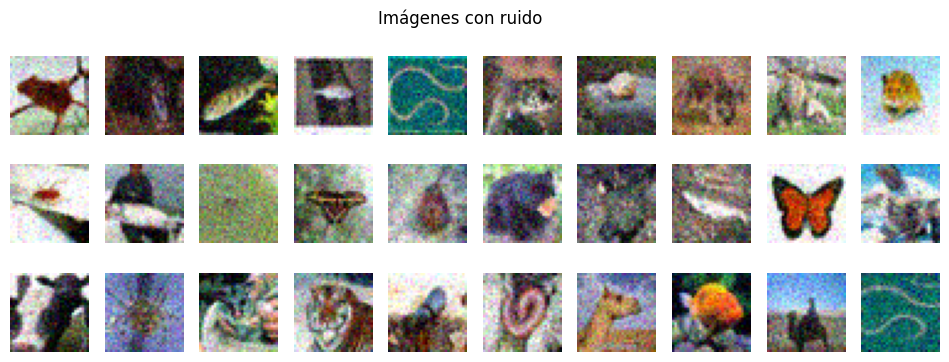

In [44]:
# ruido Gaussiano, promedio 0 y std 0.3
noise = 0.3
x_train_noisy = x_train + noise * np.random.normal(0, 0.3, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(0, 0.3, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

show(x_train_noisy, "Imágenes con ruido")

# Arquitectura

In [5]:
size = 32
channel = 3

# Encoder
inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.3)(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection para decoder
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.3)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)    # representacion latente

# Decoder
x = Conv2DTranspose(64, 3, activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x, skip]) # se introduce skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x) # imagen reconstruida

autoencoder = Model(inputs, decoded)
# se busca minimizar la loss entre la imagen de entrada y salida
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

# Entrenamiento

In [16]:
# Training
epochs = 50
batch_size = 256

history = autoencoder.fit(x = x_train_noisy, y = x_train, epochs = epochs,
                          batch_size = batch_size, shuffle = True,
                          validation_split = 0.1)

Epoch 1/50
76/76 [==============================] - 6s 40ms/step - loss: 0.5916 - val_loss: 0.6376
Epoch 2/50
76/76 [==============================] - 2s 28ms/step - loss: 0.5606 - val_loss: 0.6256
Epoch 3/50
76/76 [==============================] - 2s 27ms/step - loss: 0.5567 - val_loss: 0.6104
Epoch 4/50
76/76 [==============================] - 2s 28ms/step - loss: 0.5549 - val_loss: 0.5896
Epoch 5/50
76/76 [==============================] - 2s 26ms/step - loss: 0.5540 - val_loss: 0.5739
Epoch 6/50
76/76 [==============================] - 2s 28ms/step - loss: 0.5533 - val_loss: 0.5655
Epoch 7/50
76/76 [==============================] - 2s 28ms/step - loss: 0.5529 - val_loss: 0.5572
Epoch 8/50
76/76 [==============================] - 2s 28ms/step - loss: 0.5527 - val_loss: 0.5548
Epoch 9/50
76/76 [==============================] - 2s 29ms/step - loss: 0.5524 - val_loss: 0.5521
Epoch 10/50
76/76 [==============================] - 2s 27ms/step - loss: 0.5521 - val_loss: 0.5515
Epoch 11/

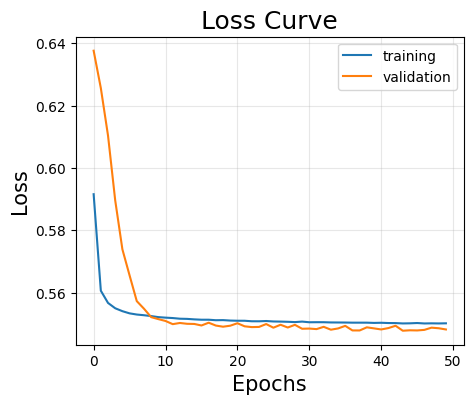

In [17]:
f = plt.figure(figsize=(5,4))
f.add_subplot()

plt.plot(history.epoch, history.history['loss'], label = "training")
plt.plot(history.epoch, history.history['val_loss'], label = "validation")

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [24]:
autoencoder.save('autoencoder.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing

In [45]:
autoencoder = load_model('autoencoder.h5', compile=False)

In [61]:
# se eligen 30 indices random
random_indices = random.sample(range(len(x_test_noisy)), 30)

# se seleccionan las 30 imagenes random
test_images = x_test_noisy[random_indices]
original_images = x_test[random_indices]

train_images = x_train_noisy[random_indices]
original_images_train = x_train[random_indices]

new_images = autoencoder.predict(test_images)
new_images_train = autoencoder.predict(train_images)

# MSE
mse_test = mean_squared_error(original_images, new_images)
mse_train = mean_squared_error(original_images_train, new_images_train)

# PSNR (Peak Signal to Noise Ratio)
psnr_test = peak_signal_noise_ratio(original_images.astype('float32'), new_images.astype('float32'))
psnr_train = peak_signal_noise_ratio(original_images_train.astype('float32'), new_images_train.astype('float32'))

print("MSE Entrenamiento:", mse_train)
print("MSE Test:", mse_test)
print("------------------------------------")
print("PSNR Entrenamiento:", psnr_test)
print("PSNR Test:", psnr_train)


1/1 [==============================] - 0s 51ms/step
MSE Entrenamiento: 0.001989131141505986
MSE Test: 0.0021698807205272163
------------------------------------
PSNR Entrenamiento: 26.63564127731704
PSNR Test: 27.01336573669042


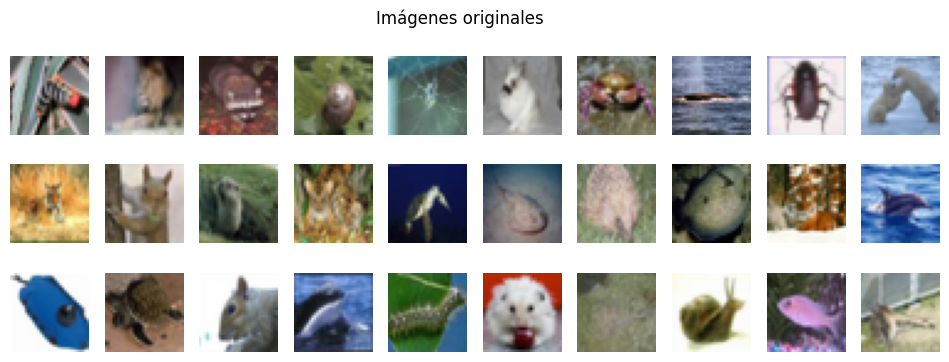

In [50]:
show(original_images, "Imágenes originales")

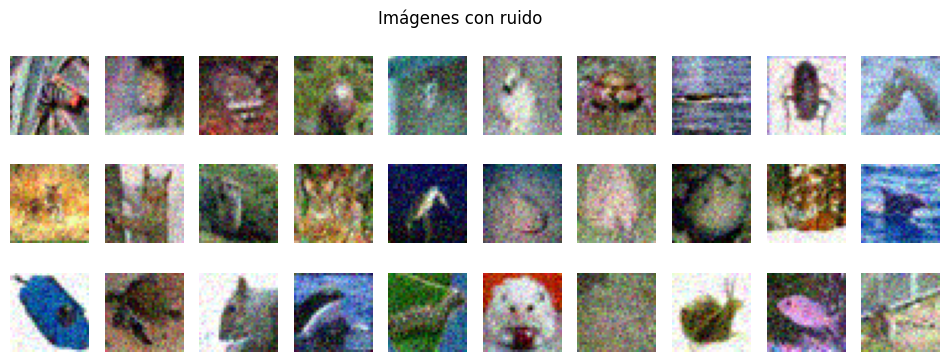

In [47]:
show(test_images, "Imágenes con ruido")

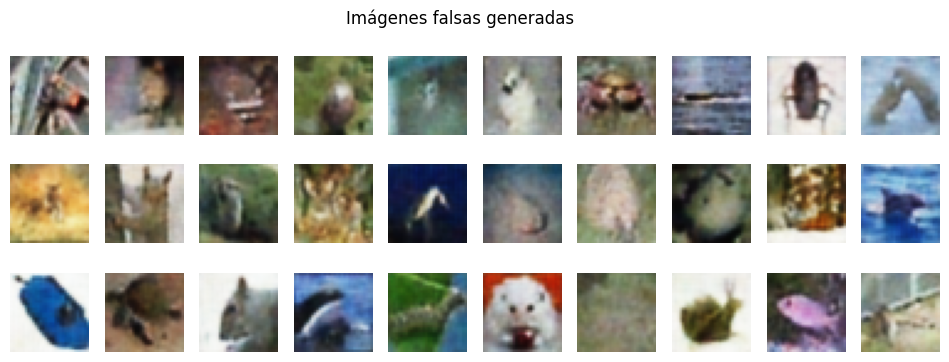

In [48]:
show(new_images, "Imágenes falsas generadas")

# Predict con Imagen Real

In [66]:
# Browse button to select an image
def browse_file():
    file_path = filedialog.askopenfilename()
    path_label.config(text=file_path)
    show_image(file_path)

# Function to show the selected image
def show_image(file_path):
    image = Image.open(file_path)
    image.thumbnail((300,300))
    photo = ImageTk.PhotoImage(image)

    # Update the label with the selected image
    image_label.config(image=photo)
    image_label.image = photo

def image_processing(file_path):
    image = Image.open(file_path)
    
    # Resize the image to (32, 32)
    resized_image = image.resize((32, 32))
    
    # Convert the image to a NumPy array
    img_array = np.array(resized_image)
    
    # Normalize the image to values between 0 and 1
    normalized_image = img_array / 255.0

    # Add noise to the image
    noisy_image = normalized_image + noise * np.random.normal(0, 0.3, size=normalized_image.shape)
    noisy_image = np.clip(noisy_image, 0, 1)

    # Expand dimensions to match the input shape expected by the model
    processed_image = np.expand_dims(noisy_image, axis=0)
    return processed_image

# Function to predict
def predict():

    # Get the selected image file
    file_path = path_label.cget("text")

    if not file_path:
        # Show error message
        messagebox.showerror("Error", "Debe seleccionar una imagen.")
        return

    # Image processing
    processed_image = image_processing(file_path)

    # Make prediction
    fake_image = autoencoder.predict(processed_image)
    # Rescale the image back to (0-255)
    fake_image = fake_image * 255.0
    fake_image = Image.fromarray(fake_image[0].astype('uint8'))
    fake_image = fake_image.resize((128,128))
    fake_photo = ImageTk.PhotoImage(fake_image)

    fake_label.config(image=fake_photo)
    fake_label.image = fake_photo

# Create the main window
root = tk.Tk()
root.title("Generación de Imagen Falsa")

# Create a label for the file path
file_label = tk.Label(root, text="Seleccione una imagen:")
file_label.pack()

# Create a button to browse files
browse_button = tk.Button(root, text="Buscar...", command=browse_file)
browse_button.pack()

# Create a label to display the selected file path
path_label = tk.Label(root, width=100, anchor="w")
path_label.pack()

# Create a label to display the selected image
image_label = tk.Label(root)
image_label.pack()

# Button to predict
predict_button = tk.Button(root, text="Probar modelo", command=predict)
predict_button.pack()

# Create a label to display the fake image
fake_label = tk.Label(root)
fake_label.pack()

# Start the main event loop
root.mainloop()

1/1 [==============================] - 0s 34ms/step
